# Malicious URL Detection using Machine Learning

## Setup

In [1]:
# standard library import
import re


# third party import
import matplotlib.pyplot as plt
import pandas as pd
from urllib.parse import urlparse
from tld import get_tld
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as met
from scipy.stats import randint
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV


C:\Users\Arvin06\AppData\Local\Temp\ipykernel_28964\1320689420.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Exploring dataset

In [3]:
# obtain the dataset as a dataframe
df = pd.read_csv("malicious_phish.csv")

# print the first 5 rows
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
# to obtain additional info on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [5]:
# to get the type of keys present
df.keys()

Index(['url', 'type'], dtype='object')

In [6]:
# to get the url distribution based on each class
df['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

In [7]:
# checking for null values
df.isnull().sum()

url     0
type    0
dtype: int64

## 2. Feature engineering

In [8]:
# feature 1: To check for presence of IP address
def has_IP(url:str) -> int:
    """Check present of IP address."""

    status = 0
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6

    if match:
        status = 1

    return status


In [9]:
# Feature 2: To count (.) dot
def count_dot(url:str) -> int:
    """Count num of dot in url."""

    return url.count('.')

# feature 3: To count dot com(.com)
def count_dot_com(url:str) -> int:
    """To count dot com."""

    return url.count('.com')

# feature 4: To count dot co(.co)
def count_dot_co(url:str) -> int:
    """To count dot co."""

    return url.count('.co')


# feature 5: To count dot net(.net)
def count_dot_net(url:str) -> int:
    """To count dot net."""

    return url.count('.net')

# feature 6: To count www
def count_www(url:str) -> int:
    """To count www"""

    return url.count('www')

# feature 7: To count @
def count_at(url:str) -> int:
    """To count @"""

    return url.count('@')

# feature 8: To count /
def count_directory(url:str) -> int:
    """To count nu of directory /"""

    urldir = urlparse(url).path
    return urldir.count('/')

# feature 9: To count //
def count_embedded_domain(url:str) -> int:
    """To count nu of //"""

    urldir = urlparse(url).path
    return urldir.count('//')

# feature 10: To check https
def https_present(url:str) -> int:
    """To check for presence of https."""

    status = 0
    https = urlparse(url).scheme
    match = str(https)
    if match=='https':
        status = 1
    return status

# feature 11: To count http
def count_http(url:str) -> int:
    """To check for http protocol."""

    return url.count('http')

# Feature 12: count % in url
def count_percent(url:str) -> int:
    """To count %"""

    return url.count('%')

# Feature 13: count ? in url
def count_ques(url:str) -> int:
    """To count ?"""

    return url.count('?')


# Feature 14: count hyphen in url
def count_hyphen(url:str) -> int:
    """To count -"""

    return url.count('-')


# Feature 15: count = in url
def count_equal(url:str) -> int:
    """To count ="""

    return url.count('=')

# feature 16: to count length of url
def url_length(url:str) -> int:
    """Check url length."""

    return len(str(url))


# Feature 17: digit count
def digit_count(url:str) -> int:
    """count number of digits in url."""

    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


# Feature 18: letter count
def letter_count(url:str) -> int:
    """to count num of letters"""

    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

# feature 19: upper case letter count
def upper_case(url:str) -> int:
    """to count num of upper case."""

    return sum(c.isupper() for c in url)

# feature 20: lower case letter count
def lower_case(url:str) -> int:
    """to count num of lower case."""

    return sum(c.islower() for c in url)


In [10]:
# feature 21: hostname length
def hostname_length(url:str) -> int:
    """Get the hostname length."""

    return len(urlparse(url).netloc)

# Feature 22: first directory length
def fd_length(url:str) -> int:
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

# Feature 23: check for url shortening service
def shortening_service(url:str) -> int:
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

# Feature 24: check for hostname match
def abnormal_url(url:str) -> int:
    """to get abnormal url"""

    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0


# Feature 26: Suspicious word
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

### 2.a Adding features to dataset

In [12]:
df_sample = df.copy()

In [13]:
df_sample['has_ip'] = df_sample['url'].apply(lambda i: has_IP(i))
df_sample["count_dot"] = df_sample['url'].apply(lambda i: count_dot(i))
df_sample["count_dot_com"] = df_sample['url'].apply(lambda i: count_dot_com(i))
df_sample["count_dot_co"] = df_sample['url'].apply(lambda i: count_dot_co(i))
df_sample["count_dot_net"] = df_sample['url'].apply(lambda i: count_dot_net(i))
df_sample["count_www"] = df_sample['url'].apply(lambda i: count_www(i))
df_sample["count_at"] = df_sample['url'].apply(lambda i: count_at(i))
df_sample["count_directory"] = df_sample['url'].apply(lambda i: count_directory(i))
df_sample["count_embedded_domain"] = df_sample['url'].apply(lambda i: count_embedded_domain(i))
df_sample["https"] = df_sample['url'].apply(lambda i: https_present(i))
df_sample["count_http"] = df_sample['url'].apply(lambda i: count_http(i))
df_sample["question_mark"] = df_sample['url'].apply(lambda i: count_ques(i))
df_sample["count_hyphen"] = df_sample['url'].apply(lambda i: count_hyphen(i))
df_sample["count_equal"] = df_sample['url'].apply(lambda i: count_equal(i))
df_sample["url_length"] = df_sample['url'].apply(lambda i: url_length(i))
df_sample["digit_count"] = df_sample['url'].apply(lambda i: digit_count(i))
df_sample["letter_count"] = df_sample['url'].apply(lambda i: letter_count(i))
df_sample["upper_case"] = df_sample['url'].apply(lambda i: upper_case(i))
df_sample["lower_case"] = df_sample['url'].apply(lambda i: lower_case(i))
df_sample["hostname_length"] = df_sample['url'].apply(lambda i: hostname_length(i))
df_sample["fd_length"] = df_sample['url'].apply(lambda i: fd_length(i))
df_sample["url_shortening"] = df_sample['url'].apply(lambda i: shortening_service(i))
df_sample["abnormal_url"] = df_sample['url'].apply(lambda i: abnormal_url(i))
df_sample["suspicious_words"] = df_sample['url'].apply(lambda i: suspicious_words(i))
df_sample["suspicious_words"] = df_sample['url'].apply(lambda i: suspicious_words(i))

In [14]:
# feature 25: tld length
df_sample['tld'] = df_sample['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1
df_sample['tld_length'] = df_sample['tld'].apply(lambda i: tld_length(i))

In [15]:
df_sample.drop("tld", axis=1, inplace=True)

In [16]:
df_sample.drop("url", axis=1, inplace=True)

In [17]:
df_sample.head()

,type,has_ip,count_dot,count_dot_com,count_dot_co,count_dot_net,count_www,count_at,count_directory,count_embedded_domain,...,digit_count,letter_count,upper_case,lower_case,hostname_length,fd_length,url_shortening,abnormal_url,suspicious_words,tld_length
0,phishing,0,2,1,1,0,0,0,0,0,...,0,13,0,13,0,0,0,0,0,-1
1,benign,0,2,1,1,0,0,0,2,0,...,1,29,0,29,0,5,0,0,0,-1
2,benign,0,2,0,0,0,0,0,3,0,...,1,25,0,25,0,7,0,0,0,-1
3,defacement,0,3,0,0,0,1,0,1,0,...,7,63,0,63,21,9,0,1,0,2
4,defacement,0,2,0,0,1,0,0,1,0,...,22,199,63,136,23,9,0,1,0,3


In [18]:
df_sample.columns

Index(['type', 'has_ip', 'count_dot', 'count_dot_com', 'count_dot_co',
       'count_dot_net', 'count_www', 'count_at', 'count_directory',
       'count_embedded_domain', 'https', 'count_http', 'question_mark',
       'count_hyphen', 'count_equal', 'url_length', 'digit_count',
       'letter_count', 'upper_case', 'lower_case', 'hostname_length',
       'fd_length', 'url_shortening', 'abnormal_url', 'suspicious_words',
       'tld_length'],
      dtype='object')

### 2.b Label encoding the target (y)

In [19]:
lb_make = LabelEncoder()
df_sample["type_code"] = lb_make.fit_transform(df_sample["type"])
df_sample["type_code"].value_counts()

type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64

In [20]:
df_sample.drop("type", axis=1, inplace=True)

In [21]:
# Target Variable/ y is isolated
target = df_sample['type_code']
target.head()

0    3
1    0
2    0
3    1
4    1
Name: type_code, dtype: int32

In [22]:
df_sample.drop("type_code", axis=1, inplace=True)
df_sample.head()

,has_ip,count_dot,count_dot_com,count_dot_co,count_dot_net,count_www,count_at,count_directory,count_embedded_domain,https,...,digit_count,letter_count,upper_case,lower_case,hostname_length,fd_length,url_shortening,abnormal_url,suspicious_words,tld_length
0,0,2,1,1,0,0,0,0,0,0,...,0,13,0,13,0,0,0,0,0,-1
1,0,2,1,1,0,0,0,2,0,0,...,1,29,0,29,0,5,0,0,0,-1
2,0,2,0,0,0,0,0,3,0,0,...,1,25,0,25,0,7,0,0,0,-1
3,0,3,0,0,0,1,0,1,0,0,...,7,63,0,63,21,9,0,1,0,2
4,0,2,0,0,1,0,0,1,0,0,...,22,199,63,136,23,9,0,1,0,3


In [23]:
features_set = df_sample.copy()
features_set.head()

,has_ip,count_dot,count_dot_com,count_dot_co,count_dot_net,count_www,count_at,count_directory,count_embedded_domain,https,...,digit_count,letter_count,upper_case,lower_case,hostname_length,fd_length,url_shortening,abnormal_url,suspicious_words,tld_length
0,0,2,1,1,0,0,0,0,0,0,...,0,13,0,13,0,0,0,0,0,-1
1,0,2,1,1,0,0,0,2,0,0,...,1,29,0,29,0,5,0,0,0,-1
2,0,2,0,0,0,0,0,3,0,0,...,1,25,0,25,0,7,0,0,0,-1
3,0,3,0,0,0,1,0,1,0,0,...,7,63,0,63,21,9,0,1,0,2
4,0,2,0,0,1,0,0,1,0,0,...,22,199,63,136,23,9,0,1,0,3


### 2.c Scaling input features

In [24]:
# scale the input feature set
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(features_set)

In [25]:
# convert back to dataframe
scaled_feature = pd.DataFrame(scaled_feature)

In [26]:
scaled_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.139829,-0.131112,0.666601,0.598871,-0.231009,-0.485023,-0.040954,-1.478722,-0.038715,-0.157077,...,-0.472396,-1.019688,-0.267447,-1.071836,-0.563635,-0.745233,-0.254988,-0.637101,-0.26713,-0.562805
1,-0.139829,-0.131112,0.666601,0.598871,-0.231009,-0.485023,-0.040954,-0.202334,-0.038715,-0.157077,...,-0.386931,-0.513751,-0.267447,-0.498308,-0.563635,-0.323868,-0.254988,-0.637101,-0.26713,-0.562805
2,-0.139829,-0.131112,-1.316598,-1.365988,-0.231009,-0.485023,-0.040954,0.435859,-0.038715,-0.157077,...,-0.386931,-0.640235,-0.267447,-0.641690,-0.563635,-0.155322,-0.254988,-0.637101,-0.26713,-0.562805
3,-0.139829,0.539700,-1.316598,-1.365988,-0.231009,1.997449,-0.040954,-0.840528,-0.038715,-0.157077,...,0.125854,0.561366,-0.267447,0.720437,1.792752,0.013223,-0.254988,1.569609,-0.26713,0.952136
4,-0.139829,-0.131112,-1.316598,-1.365988,3.408737,-0.485023,-0.040954,-0.840528,-0.038715,-0.157077,...,1.407817,4.861832,6.954458,3.337156,2.017170,0.013223,-0.254988,1.569609,-0.26713,1.457116


### 2.d Train test set splitting 

In [27]:
# the data is stratified based on the target

X_train, X_test, y_train, y_test = train_test_split(scaled_feature, target, stratify=target, test_size=0.2,shuffle=True, random_state=42)

## 3. Training ML models

### 3.a Logistic regression

In [28]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test)
print(classification_report(y_test,y_pred_log,target_names=['benign', 'defacement','phishing','malware']))

score = met.accuracy_score(y_test, y_pred_log)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.90      0.97      0.94     85621
  defacement       0.86      0.95      0.90     19292
    phishing       0.82      0.73      0.77      6504
     malware       0.80      0.47      0.59     18822

    accuracy                           0.88    130239
   macro avg       0.84      0.78      0.80    130239
weighted avg       0.88      0.88      0.87    130239

accuracy:   0.884


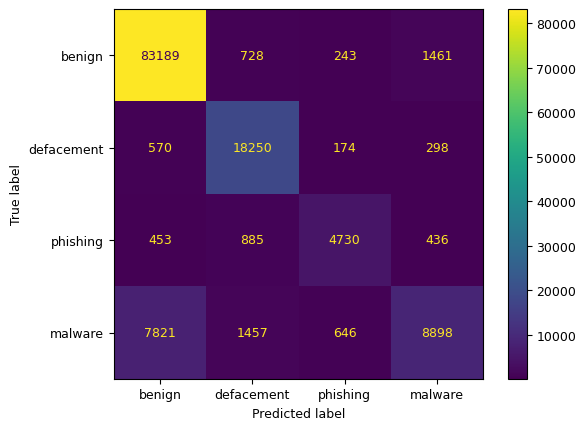

In [29]:
cm = confusion_matrix(y_test, y_pred_log)
plt.rc('font', size=9)
cc = met.ConfusionMatrixDisplay(cm, display_labels=['benign', 'defacement','phishing','malware'])
cc.plot()
plt.show()

### 3.b Decision Tree Classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)
print(classification_report(y_test,y_pred_tree,target_names=['benign', 'defacement','phishing','malware']))

score = met.accuracy_score(y_test, y_pred_tree)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.98      0.98     19292
    phishing       0.96      0.94      0.95      6504
     malware       0.87      0.85      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.94      0.94      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.959


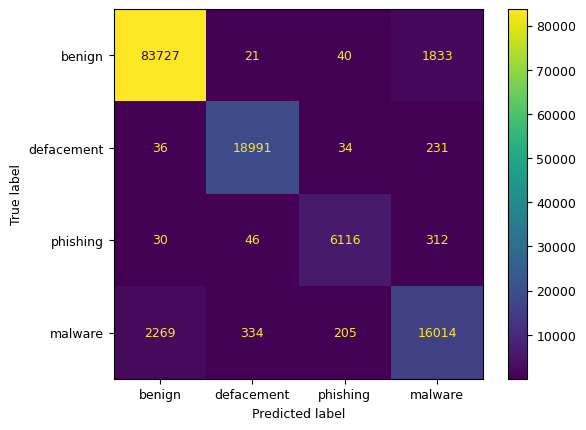

In [31]:
cm = confusion_matrix(y_test, y_pred_tree)
plt.rc('font', size=9)
cc = met.ConfusionMatrixDisplay(cm, display_labels=['benign', 'defacement','phishing','malware'])
cc.plot()
plt.show()

### 3.c Random Forest classifier

#### Hyperparameter tuning 

In [32]:
rf = RandomForestClassifier(max_features='sqrt')

rf_param = {'n_estimators': randint(low=50, high=120),
             'max_depth': randint(low=6, high=10),
             'min_samples_leaf' : randint(low=4, high=10),
             'min_samples_split' : randint(low=4, high=10)
             }

rf_random = RandomizedSearchCV(
            rf,param_distributions=rf_param, n_iter=10, cv=3,
            scoring='accuracy', random_state=42)

rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F502A4F40>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F3D67B100>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F3D67ABC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F502BA9B0>},
                   random_state=42, scoring='accuracy')

#### Model evaluation

In [33]:
rf_best_model = rf_random.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)

print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = met.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.96      0.99      0.97     85621
  defacement       0.90      0.98      0.94     19292
    phishing       0.98      0.79      0.87      6504
     malware       0.91      0.76      0.83     18822

    accuracy                           0.94    130239
   macro avg       0.94      0.88      0.90    130239
weighted avg       0.94      0.94      0.94    130239

accuracy:   0.944


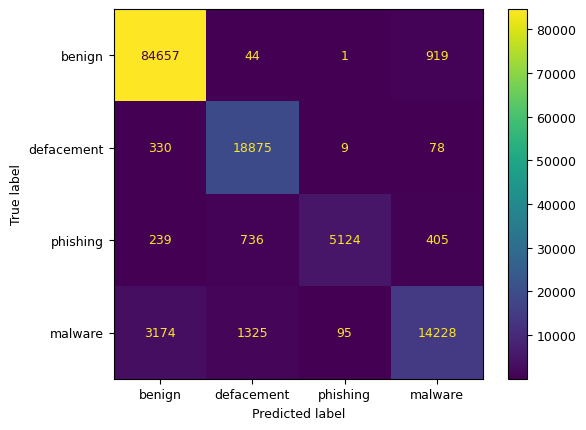

In [34]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.rc('font', size=9)
cc = met.ConfusionMatrixDisplay(cm, display_labels=['benign', 'defacement','phishing','malware'])
cc.plot()
plt.show()

#### Optimized Random Forest parameters

In [35]:
rf_random.best_params_

{'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 9,
 'n_estimators': 98}

### 3.d XGBoost Classifier

#### Hyperparameter tuning

In [36]:
xgb_c = xgb.XGBClassifier()

xgb_params = {
               'max_depth': randint(low=6, high=10),
               'n_estimators': randint(low=6, high=10)
              }

xgb_random_search = RandomizedSearchCV(
            xgb_c,param_distributions=xgb_params, n_iter=10, cv=3,
            scoring='accuracy', random_state=42)

xgb_random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F44105D80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F441051B0>},
                   random_state=42, scoring='accuracy')

#### Model evaluation

In [37]:
xgb_best_model = xgb_random_search.best_estimator_

y_pred_xgb = xgb_best_model.predict(X_test)
print(classification_report(y_test,y_pred_xgb,target_names=['benign', 'defacement','phishing','malware']))

score = met.accuracy_score(y_test, y_pred_xgb)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.95      0.98      0.97     19292
    phishing       0.96      0.86      0.91      6504
     malware       0.91      0.81      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.91      0.93    130239
weighted avg       0.95      0.96      0.95    130239

accuracy:   0.955


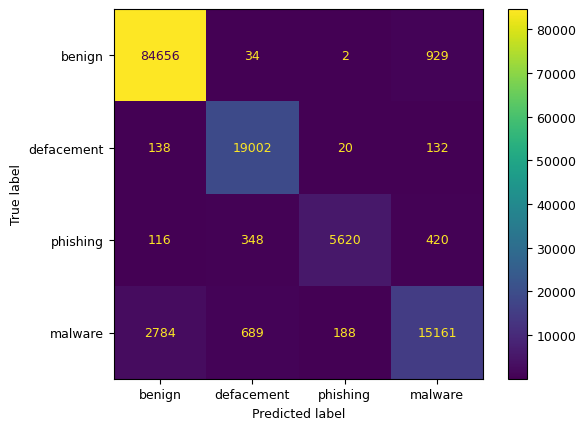

In [38]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.rc('font', size=9)
cc = met.ConfusionMatrixDisplay(cm, display_labels=['benign', 'defacement','phishing','malware'])
cc.plot()
plt.show()

#### Optimized XGBoost parameters

In [39]:
xgb_random_search.best_params_

{'max_depth': 9, 'n_estimators': 9}

### 3.e LightGBM Classifier

#### Hyperparamter tuning

In [40]:
lgb = lgb.LGBMClassifier(objective='multiclass',boosting_type= 'gbdt')

lgb_params = {
               'max_depth':randint(low=6, high=10),
               'n_estimators': randint(low=20, high=100),
              }

lgb_random_search = RandomizedSearchCV(
            lgb,param_distributions=lgb_params, n_iter=10, cv=3,
            scoring='accuracy', random_state=42)

lgb_random_search.fit(X_train,y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 347301, number of used features: 25
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909717
[LightGBM] [Info] Start training from score -2.996945
[LightGBM] [Info] Start training from score -1.934316
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(objective='multiclass'),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F44107130>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F44105DE0>},
                   random_state=42, scoring='accuracy')

#### Model evaluation

In [41]:
lgb_best_model = lgb_random_search.best_estimator_

y_pred_lgb = lgb_best_model.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = met.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.961


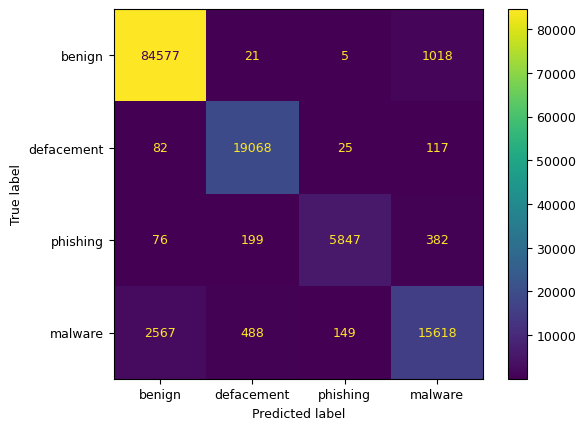

In [42]:
cm = confusion_matrix(y_test, y_pred_lgb)
plt.rc('font', size=9)
cc = met.ConfusionMatrixDisplay(cm, display_labels=['benign', 'defacement','phishing','malware'])
cc.plot()
plt.show()

#### Optimized LightGBM parameters

In [43]:
lgb_random_search.best_params_

{'max_depth': 8, 'n_estimators': 94}

## 4. Ensemble models

### 4.a Voting ensemble classifier

In [44]:
# try using only one decision tree
new_estimators = [
                 ("tree",tree_clf),
                 ("lgb", lgb_best_model),
                 ("xgn", xgb_best_model),
                 ("rf", rf_best_model)
                ]

voting_clf = VotingClassifier(estimators=new_estimators, voting='soft')

voting_clf.fit(X_train,y_train)

y_pred_vote = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred_vote, target_names=['benign', 'defacement','phishing','malware']))

score = met.accuracy_score(y_test, y_pred_vote)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 25
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-sc

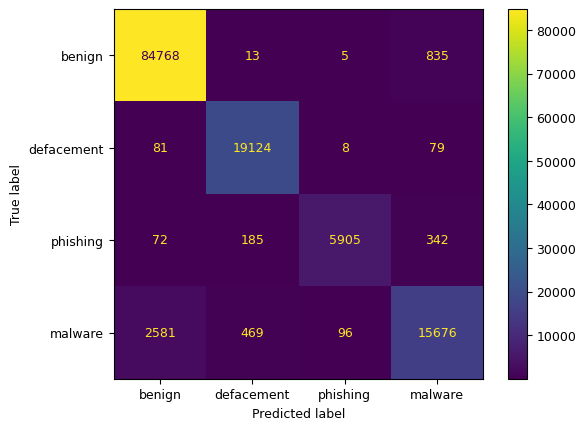

In [45]:
cm = confusion_matrix(y_test, y_pred_vote)
plt.rc('font', size=9)
cc = met.ConfusionMatrixDisplay(cm, display_labels=['benign', 'defacement','phishing','malware'])
cc.plot()
plt.show()

### 4.b Stacking ensemble classifier

In [46]:
stacking_clf = StackingClassifier(
    estimators=[
                ("tree1",tree_clf),
                ("lgb", lgb_best_model),
                 ("xgn", xgb_best_model),
                 ("rf", rf_best_model)
               ],
    final_estimator=log_clf,
    cv=5  # number of cross-validation folds
)

stacking_clf.fit(X_train,y_train)

y_pred_stack = stacking_clf.predict(X_test)
print(classification_report(y_test,y_pred_stack,target_names=['benign', 'defacement','phishing','malware']))
score = met.accuracy_score(y_test, y_pred_stack)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 25
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad

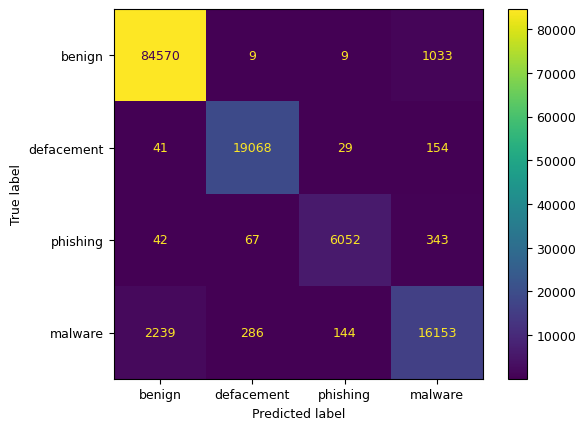

In [47]:
cm = confusion_matrix(y_test, y_pred_stack)
plt.rc('font', size=9)
cc = met.ConfusionMatrixDisplay(cm, display_labels=['benign', 'defacement','phishing','malware'])
cc.plot()
plt.show()

### In conclusion, both ensemble models achieved a higher accuracy than the best base classifier LightGBM(96.1%), where voting classifier achieved an accuracy of 96.3% and stacking classifier achieved an accuracy of 96.6%. 